In [2]:
using Plots, StatsPlots
include("src/SFGP_classification-learnable.jl")
using Flux
using StatsBase
using CSV, DataFrames

In [3]:
df = CSV.File("./data/heart.csv",header = false) |> DataFrame
df = df[(df[:,12].!="?").*(df[:,13].!="?"),:]

df[!,12] = parse.(Float64,string.(df[:,12]))
df[!,13] = parse.(Float64,string.(df[:,13]))

df = Matrix(df)

297×14 Matrix{Float64}:
 63.0  1.0  1.0  145.0  233.0  1.0  2.0  150.0  0.0  2.3  3.0  0.0  6.0  0.0
 67.0  1.0  4.0  160.0  286.0  0.0  2.0  108.0  1.0  1.5  2.0  3.0  3.0  2.0
 67.0  1.0  4.0  120.0  229.0  0.0  2.0  129.0  1.0  2.6  2.0  2.0  7.0  1.0
 37.0  1.0  3.0  130.0  250.0  0.0  0.0  187.0  0.0  3.5  3.0  0.0  3.0  0.0
 41.0  0.0  2.0  130.0  204.0  0.0  2.0  172.0  0.0  1.4  1.0  0.0  3.0  0.0
 56.0  1.0  2.0  120.0  236.0  0.0  0.0  178.0  0.0  0.8  1.0  0.0  3.0  0.0
 62.0  0.0  4.0  140.0  268.0  0.0  2.0  160.0  0.0  3.6  3.0  2.0  3.0  3.0
 57.0  0.0  4.0  120.0  354.0  0.0  0.0  163.0  1.0  0.6  1.0  0.0  3.0  0.0
 63.0  1.0  4.0  130.0  254.0  0.0  2.0  147.0  0.0  1.4  2.0  1.0  7.0  2.0
 53.0  1.0  4.0  140.0  203.0  1.0  2.0  155.0  1.0  3.1  3.0  0.0  7.0  1.0
 57.0  1.0  4.0  140.0  192.0  0.0  0.0  148.0  0.0  0.4  2.0  0.0  6.0  0.0
 56.0  0.0  2.0  140.0  294.0  0.0  2.0  153.0  0.0  1.3  2.0  0.0  3.0  0.0
 56.0  1.0  3.0  130.0  256.0  1.0  2.0  142.0  1.0 

In [4]:
X = transpose(df)[1:end-1,:]
y = transpose(df)[end:end,:]
y[y.!=0] .= 1 

137-element view(::Vector{Float64}, [2, 3, 7, 9, 10, 13, 17, 23, 24, 25  …  286, 288, 289, 290, 292, 293, 294, 295, 296, 297]) with eltype Float64:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [5]:
function observed(mm::SFGP,m,s)
    probs = getProbs(m,s,mm.lower,mm.upper)[:]
    vals = (mm.vals)[:]
    
    dist = DiscreteNonParametric(σ.(vals),probs)
    
    mm = mean(dist)
    ss = std(dist)
    lower = quantile(dist,0.05)
    upper = quantile(dist,0.95)
    
    return mm,ss,lower,upper,dist
end

observed (generic function with 1 method)

206.62497227309896
205.12062220662878
205.021277711682
205.2035477944529
205.00683987107894
205.34715833613603
205.03484048732054
205.23950288145164
204.98992668412774
205.0937647574074
205.33999887272608
205.00569346731984
204.99342710327318
204.98366450085882


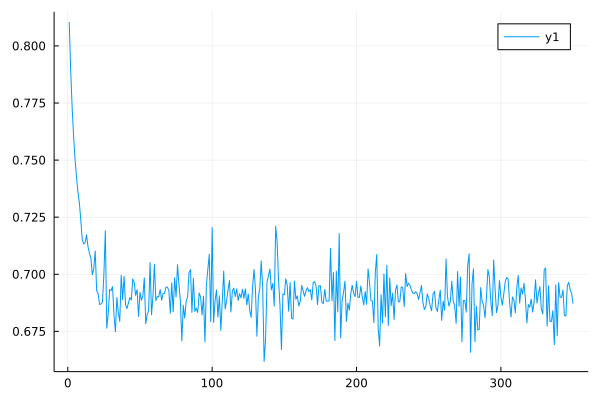

In [6]:
import Random
Random.seed!(1234)

sfgp = SFGP(SVGP(10,13),30,3)

x1g = collect(range(-4,4,length=50))
x2g = collect(range(-4,4,length=50))
x1grid = (x1g' .* ones(length(x2g)))[:] 
x2grid = (ones(length(x1g))' .* x2g)[:]
Xgrid = Matrix(transpose(hcat(x1grid,x2grid)))

params = Flux.params(sfgp)
opt = ADAM(0.05)


losses = []


for i in 1:350
    grads = Zygote.gradient(() -> sample_elbo(sfgp,X,y),params)
    Flux.Optimise.update!(opt,params,grads)
    push!(losses,sample_elbo(sfgp,X,y))
    
    if i%25==0
        println(elbo(sfgp,X,y))
    end
end

plot(losses)

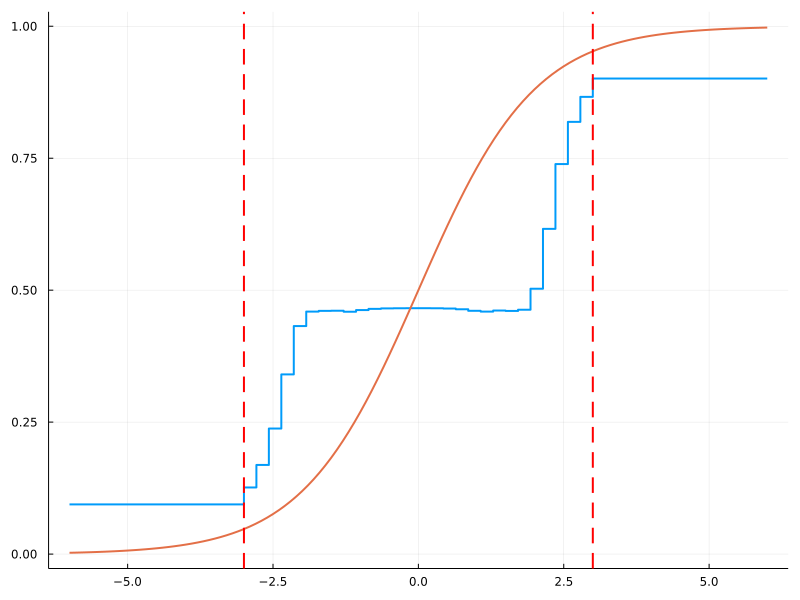

In [7]:
plot(vcat(-6,sfgp.upper[1:end-1],6),σ.(vcat(sfgp.vals[1],sfgp.vals)),legend=:none, linetype=:steppre,size=(800,600),lw=2,fmt=:png)

plot!(collect(-6:0.1:6),σ.(collect(-6:0.1:6)),lw=2)
vline!([-3,3],color=:red,s=:dash,lw=2)